## Task-1:
1) Download the cifra-100 dataset for 'coarse' label (20 superclasses) \https://www.cs.toronto.edu/~kriz/cifar.html
2) Print each label (train and test) volume as a dataframe (preparing three columns of class, train, test) \
3) Take one image from each class (20 superclasses) and plot them side-by-side in (4,5)-shape

In [1]:
!pip install tensorflow-addons

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tensorflow.keras import Sequential, optimizers, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape, Activation, Dropout
from tensorflow.keras.datasets import cifar100 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow_addons.metrics import F1Score

### Download data

In [3]:
(x_train, y_train),(x_test, y_test) = cifar100.load_data(label_mode="coarse")

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
x_train = x_train.reshape(50000, 32, 32, 3).astype('float32')

x_test = x_test.reshape(10000, 32, 32, 3).astype('float32')

# x_train/=255 #normalize data

# x_test/=255 #normalize data

In [7]:
x_train_mean = np.mean(x_train, axis=(0,1,2))
x_train_std = np.std(x_train, axis=(0,1,2))
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [8]:
classes = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 
           'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 
           'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 
           'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 
           'trees', 'vehicles_1', 'vehicles_2']

/home/zapjanice/.pyenv/versions/3.8.6/envs/personal_project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/zapjanice/.pyenv/versions/3.8.6/envs/personal_project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


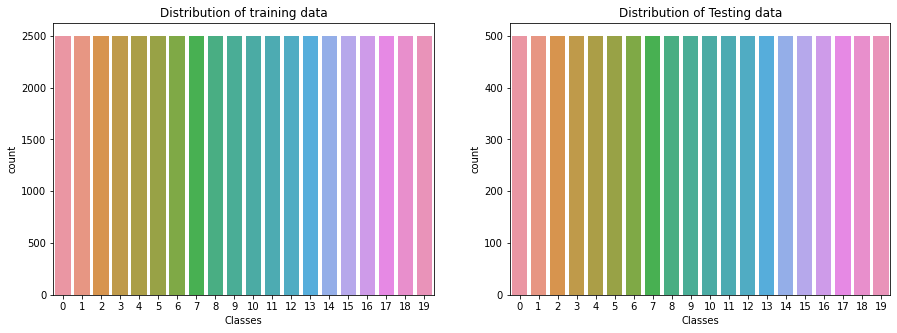

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

### Put into dataframe

In [10]:
train_no = (50000*32*32)
test_no = (10000*32*32)
train_arr = np.reshape(x_train, (train_no, 3))
train_df = pd.DataFrame(train_arr)
test_arr = np.reshape(x_test, (test_no, 3))
test_df = pd.DataFrame(test_arr)

In [11]:
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

### Plot unique class images

In [12]:
x_list = []
y_list = []
def unique_image(x, y):
    u, indices = np.unique(y, return_index=True)
    for number in indices:
        x_list.append(x[number])
        y_list.append(y[number])

In [13]:
unique_image(x_train, y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

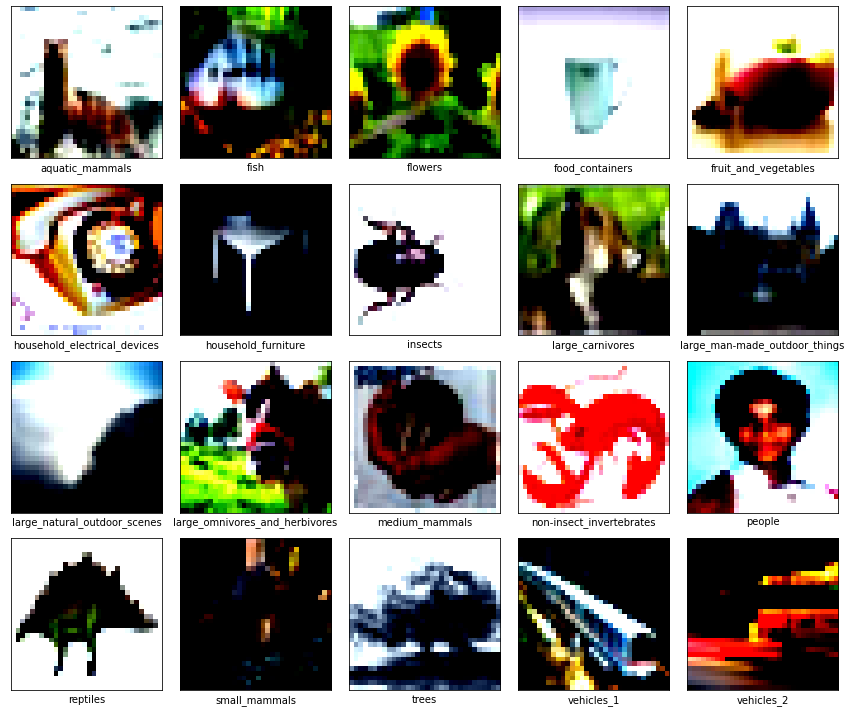

In [14]:
plt.figure(figsize=(12,10))
for image in range(0,20):
    i=image
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j=i+0
    data_plot = x_list[j]
    plt.imshow(data_plot)
    plt.xlabel(classes[y_list[j].item()])
    plt.tight_layout()
plt.show()

##### Picture comments
The picture of non-insect_invertebrates and reptiles seem to be a drawing. 
<br> The image of the tree is black and white
<br> Vehicle 1 and vehicle 2 looks similar and might be hard to distinguish. 

In [15]:
# img = Image.open(r"C:\Users\System-Pc\Desktop\tree.jpg")
# r, g, b = img.split()
# len(r.histogram())
# ### 256 ###
  
# r.histogram()

## Task-2:
1) Take any computer vision architectures (e.g. VGG, ResNet, whatever you want) and find out the accuracy & f1-score.\
2) Please give your thoughts on the results

In [16]:
y_train = to_categorical(y_train, num_classes=20)
y_test = to_categorical(y_test, num_classes=20)
#change shape of y_train/test

### Using model VGG16

In [ ]:
model_vgg = VGG16(weights=None, classes=len(classes), input_shape=(32, 32, 3))

model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', F1Score(num_classes=20, average='macro')])

history_vgg = model_vgg.fit(x=x_train, y=y_train, batch_size=128, epochs=40, verbose=2,  callbacks=EarlyStopping(patience=5), validation_split=0.3, shuffle=True)

Epoch 1/40


/home/zapjanice/.pyenv/versions/3.8.6/envs/personal_project/lib/python3.8/site-packages/tensorflow/python/keras/metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


274/274 - 1604s - loss: 3.0135 - accuracy: 0.0494 - f1_score: 0.0298 - val_loss: 2.9964 - val_accuracy: 0.0494 - val_f1_score: 0.0047
Epoch 2/40
274/274 - 5555s - loss: 2.9960 - accuracy: 0.0485 - f1_score: 0.0244 - val_loss: 2.9960 - val_accuracy: 0.0467 - val_f1_score: 0.0045
Epoch 3/40
274/274 - 2096s - loss: 2.9958 - accuracy: 0.0506 - f1_score: 0.0091 - val_loss: 2.9961 - val_accuracy: 0.0467 - val_f1_score: 0.0045
Epoch 4/40
274/274 - 1989s - loss: 2.9958 - accuracy: 0.0495 - f1_score: 0.0152 - val_loss: 2.9962 - val_accuracy: 0.0467 - val_f1_score: 0.0045
Epoch 5/40


In [ ]:
res_vgg = model_vgg.evaluate(x_test, y_test, verbose=2)

print(f'The accuracy is of {res_vgg[1]*100:.3f}% compared to a chance level of {1./20*100} %')

***
##### VGG16: comments
The model results for VGG16 is the same as the baseline model of 5%. 
<br>It is not a good model because the accuracy is about the same as randomly choosing a label. 
***

### Using model resnet

In [ ]:
model_resnet = ResNet50(weights=None, classes=len(classes), input_shape=(32, 32, 3))

model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', F1Score(num_classes=20, average='macro')])

history_resnet = model_resnet.fit(x=x_train, y=y_train, batch_size=64, epochs=40, verbose=2, callbacks=EarlyStopping(patience=20), validation_split=0.3, shuffle=True)

In [ ]:
res_resnet = model_resnet.evaluate(x_test, y_test, verbose=2)

print(f'The accuracy is of {res_resnet[1]*100:.3f}% compared to a chance level of {1./20*100} %')

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history_resnet)
plt.show()

***
##### ResNet model comments
The accuracy for the ResNet50 model is **8.8 times** higher than the baseline accuracy. 
<br> The f1 score which is the harmonic mean of precision and recall has about the same value as the accuracy. 

When plotting the history of loss and accuracy between the training set and validation set, we can see that the model overfits from about the 15 epoch. 
<br> - The accuracy is improving on the train set, however the accuracy of the validation set remains the same. 
<br> - The loss is decreasing on the train set, however, the loss for the validation set remains the same. 

Solutions: 
<br>- apply dropout or regularization techniques
<br>- train until 15 epochs 
***

### Trying my own model

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3))) #create a covolution kernel
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2))) #take the maximum value over 2,2 window
    model.add(layers.Dropout(0.2)) #drop 20% of the input units 

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(20, activation='softmax'))
    
    return model  

In [ ]:
optimizer_01= optimizers.Adam(learning_rate=0.001)

def compile_model(model):
    model.compile(loss='categorical_crossentropy', #computes the crossentropy loss between labels and prediction.
              optimizer=optimizer_01,
              metrics=['accuracy', F1Score(num_classes=20, average='macro')])
    
    return model 

In [ ]:
model = initialize_model()
model = compile_model(model)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = initialize_model()
model = compile_model(model)

es = EarlyStopping(patience=30, verbose=2)

history = model.fit(x_train, y_train, 
                    validation_split=0.3,
                    callbacks=[es], 
                    epochs=100, 
                    batch_size=64)

In [ ]:
plot_history(history)
plt.show()

In [ ]:
res = model.evaluate(x_test, y_test, verbose=2)

print(f'The accuracy is of {res[1]*100:.3f}% compared to a chance level of {1./20*100} %')

***
##### Own model comments
The accuracy for theis model is **11.6 times** higher than the baseline accuracy. 

When plotting the history of loss and accuracy between the training set and validation set, we can see that the model starts to overfitt after 20 epochs. 

Solutions:
<br>- train until 20 epochs
***

## Task-3:
1) Please explain the regularization techniques used in the architecture you chose (e.g. drop-out technique, etc)\
2) Please briefly give a reason why you chose that architecture.

***
Regularization techniques: 
<br> A technique to change the learning algorithm so that it can generalize better and to ultimately improve the model’s performance on unseen data.  

Dropout method: 
<br> - I used this method because it is the most used technique with good results. It helps the learning algorithm generalize better. 
<br> - For this method, at every iteration nodes are randomly selected and removed along with all of their incoming and outgoing connections.

Other regularization methods:
<br> 1. L1 & L2 regularization
<br> - Apply penalties on layer parameters or layer activity during optimization. Penalties are summed into the loss function that the network optimizes.

***

THANK YOU VERY MUCH FOR THIS CHALLENGE! 